<a href="https://colab.research.google.com/github/melodyrous/MIASHS2/blob/main/opti%26regul/4_ridge_regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Une analyse de la régularisation Ridge ☕️☕️☕️

La régularisation Ridge, aussi appelée *weight decay* en *deep learning* ou encore pénalité $\ell_2$, possède des propriétés fascinantes qui (1) expliquent ses performances et (2) permettent de la relier à d'autres stratégies de régularisation empiriques telles que la *data augmentation*, le ou encore le *dropout*.

Nous nous concentrerons dans cette séquence sur les problèmes linéaires.

## I. Ridge, une question de stabilité

Soit $X\in\mathbb{R}^{p\times n}$ la matrice de nos données avec $p$ individus en dimension $n$. Soit $\boldsymbol{y}\in\mathbb{p}$ nos labels. Notre objectif est de trouver un vecteur $\beta\in\mathbb{R}^n$ tel que la quantité suivante soit minimisée : 

$$\hat{\beta}=\text{argmin}_{\beta\in\mathbb{R}^n}\lVert X\beta-\boldsymbol{y}\rVert_2^2.$$

Nous avons pu constater que si $X^TX$ était inversible, ce problème possédait une unique solution calculable en annulant le gradient :

$$\hat{\beta}=(X^TX)^{-1}X^T\boldsymbol{y}.$$

Lorsque $X^TX$ n'est pas inversible, une solution (de norme minimale) est :

$$\hat{\beta}=X^\dagger \boldsymbol{y},$$

où $X^\dagger$ est le pseudo-inverse de Moore-Penrose. Nous avons pu constater dans les séquences précédentes que le nombre d'individus dans $X$ affectait considérablement notre estimation de $\hat{\beta}$ et cela était visible au travers de l'effet *double descente*. Nous illustrons ce phénomène à nouveau ci-dessous. On génère un jeu de données synthétique en jouant sur le nombre d'invididus dans notre jeu d'apprentissage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# dimension de l'espace
d = 50
# repetition de l'experience
redo = 50

# vrai parametre utilise pour generer nos donnees
beta = np.random.uniform(-2, 2, size=(d, 1))

mu = [0 for _ in range(d)]
cov = np.diag([1 for _ in range(d)])

test_size = 500
X_test = np.random.multivariate_normal(mean=mu, cov=cov, size=test_size)
y_test = np.dot(X_test, beta) + np.random.normal(0, 1, size=(test_size, 1))

errors = []
train_errors = []
for m in range(1, 100):
    error = 0
    train_error = 0
    for j in range(redo):
        # dataset construction
        X = np.random.multivariate_normal(mean=mu, cov=cov, size=m)
        y = np.dot(X, beta) + np.random.normal(0, 1, size=(m, 1))
        
        # param estimation
        beta_pinv = np.dot(np.linalg.pinv(X), y)
        
        # risk estimation
        error += ((np.dot(X_test, beta_pinv)-y_test)**2).sum()/(test_size*redo)
        train_error += ((np.dot(X, beta_pinv)-y)**2).sum()/(m*redo)
    train_errors.append(train_error)
    errors.append(error)

In [4]:
def plot_losses(errors, train_errors):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot([i for i in range(1, len(errors)+1)], errors, label="Risk estimation")
    plt.axvline(x=d, color='k', linewidth=2.0, linestyle='--', label='Dimension')
    plt.legend()
    plt.yscale('log')
    plt.title('Test error')
    plt.xlabel('Dataset size')
    plt.ylabel('Error')
    plt.subplot(1, 2, 2)
    plt.plot([i for i in range(1, len(train_errors)+1)], train_errors, label="Train error")
    plt.axvline(x=d, color='k', linewidth=2.0, linestyle='--', label='Dimension')
    plt.legend()
    plt.xlabel('Dataset size')
    plt.ylabel('Error')
    plt.title('Train error')
    plt.show()

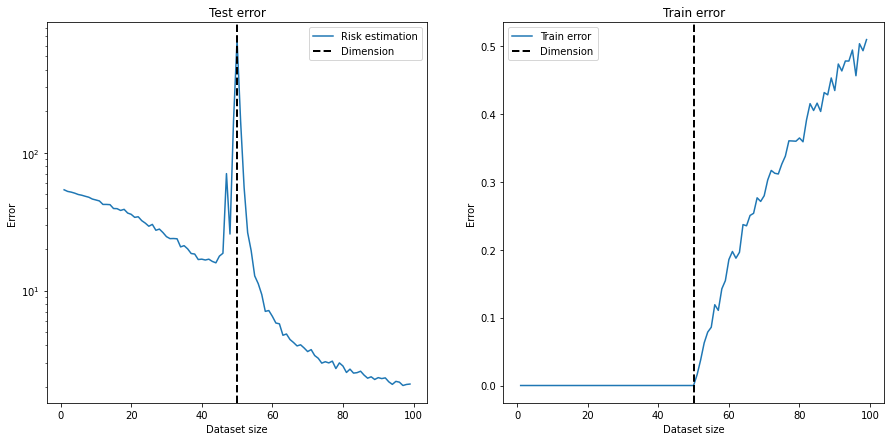

In [5]:
plot_losses(errors, train_errors)

Nous avons donc un double (sans jeu de mots) problème ici. Lorsque $X^TX$ n'est pas inversible, nous devons choisir une inverse parmi une infinité : c'est la région à gauche de la ligne vertical en pointillé. La solution $X^\dagger\boldsymbol{y}$ est celle de norme minimale, la préférable, mais le problème reste mal posé. Lorsque $X^TX$ est presque inversible les performances de généralisation sont particulièrement mauvaises.

Un autre problème apparaît. Lorsque $X^TX$ est presque inversible (i.e. son déterminant est très proche de $0$), son inverse est très instable. De toutes petites perturbations de $X$ affectent très significativement $(X^TX)^{-1}$. L'exemple suivant illustre ce problème. Considérons le système d'équations suivant :

$$Ax=y$$

In [7]:
A = np.array([[1.98, 2.], [1., 1.01]])
print('Soit une matrice A=\n', A)

Soit une matrice A=
 [[1.98 2.  ]
 [1.   1.01]]


In [8]:
x = np.array([[1], [1]])
y = np.dot(A, x)
print('Nos données sont x=\n', x, '\n et nos labels y=\n', y)

Nos données sont x=
 [[1]
 [1]] 
 et nos labels y=
 [[3.98]
 [2.01]]


Imaginons maintenant (comme c'est le cas en machine learning) que nous n'observons que $A$ (la matrice qui contiendrait nos données) et $y$ (les labels). Nous cherchons à déterminer l'inconnue $x$. C'est très facile car ici tout est déterministe et $A$ est bien inversible ($\text{det}(A)\neq 0$) :

$$\hat{x}=A^{-1}y$$

In [9]:
x_hat = np.dot(np.linalg.inv(A), y)
print('Notre prédiction pour x, x_hat=\n', x_hat)

Notre prédiction pour x, x_hat=
 [[1.]
 [1.]]


Tout marche très bien. Cependant, en pratique, nos données ne sont que rarement aussi propres. Imaginons que notre collecte soit entâchée d'un petit peu de bruit et arrondissons $y$.

In [10]:
y_round = np.round(y)
print(
    'Notre arrondi y_round=\n', y_round, 
    '\n On remarque que l\'écrat à y est très petit :\n', y_round-y
)

Notre arrondi y_round=
 [[4.]
 [2.]] 
 On remarque que l'écrat à y est très petit :
 [[ 0.02]
 [-0.01]]


Calculons maintenant l'inconnue $x$ associée à ces nouvelles observations.

In [11]:
x_hat = np.dot(np.linalg.inv(A), y_round)
print('Notre prédiction pour x, x_hat=\n', x_hat)

Notre prédiction pour x, x_hat=
 [[-200.]
 [ 200.]]


Le résultat est catastrophiquement mauvais. Une perturbation ridicule des $y$ a entraîné un effet de très grande ampleur sur nos estimateurs $\hat{x}$. Ce problème qui apparaît dans l'effet double descente et ici est lié au conditionnement de la matrice $X^TX$ (ici la matrice $A$). Son conditionnement est le ratio de sa plus grande valeur propre et de sa plus petite valeur propre. Elles sont ici :

In [12]:
eigenvalue = np.linalg.eig(A)[0]
eigen_ratio = np.max(eigenvalue)/np.min(eigenvalue)
print('Le conditionnement donne :', eigen_ratio)

Le conditionnement donne : -44702.49997761842


La valeur semble déraisonnablement grande lorsqu'on la compare aux valeurs de nos données. L'idée est ainsi d'accroître les valeurs propres lors du calcul de l'inverse :

$$X^+=(X^TX+\lambda I)^{-1}X^T,$$

où $X^+$ est une pseudo-inverse régularisée. En rajoutant $\lambda$ dans la diagonale, le ratio de la plus grande valeur propre avec la plus petite devient :

$$\frac{\gamma_{\text{max}}+\lambda}{\gamma_{\text{min}}+\lambda},$$

où $\gamma$ sont les dites valeurs propres. Reprenons notre exemple et calculons notre pseudo-inverse régularisée :

**<span style='color:blue'> Exercice</span>** 
**Proposez ci-dessous l'inverse régularisée de $A$.**



 ----

In [13]:
I = np.eye(2)
lambda_ = 0.1
# on calcule notre régularisation et la pseudo inverse
####### Complete this part ######## or die ####################
A_inv_regularized = np.dot(np.linalg.inv(np.dot(A.T, A)+lambda_*I), A.T)
###############################################################

x_hat = np.dot(A_inv_regularized, y_round)
print('Notre prédiction pour x, x_hat=\n', x_hat)


Notre prédiction pour x, x_hat=
 [[0.9879906]
 [0.9979662]]


On retombe presque sur la valeur initiale qu'on aurait voulu obtenir. On constatera de plus que la valeur de la régularisation "$0.1$" est ridiculement faible.

Nous avons certes pu obtenir une pseudo-inverse régularisée, mais notre objectif reste de minimiser une erreur de prédiction d'un modèle. Quel est le lien entre ce pseudo-inverse régularisé et notre problème intial ? Il se trouve que cela revient en fait à résoudre le problème d'optimisation suivant :

$$\text{argmin}_{\beta\in\mathbb{R}^n}\lVert X\beta-\boldsymbol{y}\rVert_2^2,\text{ s.t. }\lVert\beta\rVert_2\leq c,$$

pour une constante $c>0$. En passant au Lagragien, on obtient ainsi : 

$$\text{argmin}_{\beta\in\mathbb{R}^n}\lVert X\beta-\boldsymbol{y}\rVert_2^2+\lambda\lVert\beta\rVert_2,$$
pour $\lambda>0$.

Annulons le gradient afin de montrer que la solution de ce problème est-celle donnée plus haut.

$$\nabla (\lVert X\beta-\boldsymbol{y}\rVert_2^2+\lambda\lVert\beta\rVert_2)=2X^TX\beta-2X^Ty+2\lambda\beta=2(X^TX+\lambda I)\beta-2X^T \boldsymbol{y},$$

En annulant, on obtient : 

$$\hat{\beta}=(X^TX+\lambda I)^{-1}X^T\boldsymbol{y}=X^+\boldsymbol{y}.$$
Si $X^TX$ n'était pas inversible, $X^TX+\lambda I$ l'est nécessairement. On retrouve bien la même solution. C'est bien ce problème des moindres carrés régularisés qu'on appelle Ridge. Reprenons maintenant l'effet double descente !

**<span style='color:blue'> Exercice</span>** 
**Proposez ci-dessous la pseudo-inverse régularisée de $X$.**



 ----

In [15]:
d = 50
redo = 50

lambda_=0.1

beta = np.random.uniform(-2, 2, size=(d, 1))

mu = [0 for _ in range(d)]
cov = np.diag([1 for _ in range(d)])

test_size = 500
X_test = np.random.multivariate_normal(mean=mu, cov=cov, size=test_size)
y_test = np.dot(X_test, beta) + np.random.normal(0, 1, size=(test_size, 1))

errors = []
train_errors = []
for m in range(1, 100):
    error = 0
    train_error = 0
    for j in range(redo):
        # dataset construction
        X = np.random.multivariate_normal(mean=mu, cov=cov, size=m)
        y = np.dot(X, beta) + np.random.normal(0, 1, size=(m, 1))
        
        # param estimation
        ####### Complete this part ######## or die ####################
        pseudo_reg_inv = np.linalg.inv(np.dot(X.T, X)+ lambda_ * np.eye(d)).dot(X.T)
        ###############################################################
        
        beta_pinv = np.dot(pseudo_reg_inv, y)
        
        # risk estimation
        error += ((np.dot(X_test, beta_pinv)-y_test)**2).sum()/(test_size*redo)
        train_error += ((np.dot(X, beta_pinv)-y)**2).sum()/(m*redo)
    train_errors.append(train_error)
    errors.append(error)


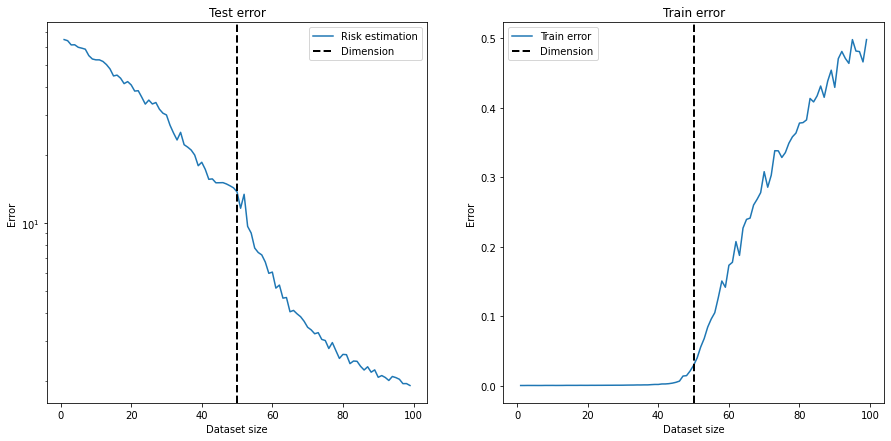

In [16]:
plot_losses(errors, train_errors)




La régularisation en rendant notre problème beaucoup plus stable a permis de gommer cet effet double descente. L'inversion la matrice $X^TX+\lambda I$ est beaucoup moins sensible aux bruits présents dans la matrice $X$. Notre problème généralise mieux lorsque la taille du jeu de données est faible voire critique (proche de la dimension).

## II. Ridge et la *data augmentation*

Nous allons ici étudier la *data augmentation* du point de vue de Ridge.

Les problèmes évoqués précédemment peuvent se résoudre assez facilement en augmentant le nombre d'invididus dans notre jeu d'apprentissage. En effet, le mauvais conditionnement de $X^TX$ vient du fait que les vecteurs lignes de $X$ ne sont pas générateurs (au sens de l'algèbre) de l'espace $\mathbb{R}^n$ ou, s'ils le sont, c'est via une composante orthogonale de taille très réduite. Plus le nombre d'individus dans $X$ devient important, plus il est probable qu'une forte composante dans chaque dimension de l'espace existe.  Cependant, labéliser de nouvelles données peut être extrêmement couteux en temps de travail. Une alternative est de créer des données synthétiques. Nous allons étudiers quelques stratégies.

Considérons dans un premier temps le problème Ridge ci-dessous :

In [ ]:
import numpy as np

In [ ]:
# on est en dimension 10
n = 10

noise = 1

lambda_=2.

beta = np.random.uniform(-2, 2, size=(n, 1))

mu = [0 for _ in range(n)]
cov = np.diag([1 for _ in range(n)])

p = 100

redo = 100

In [ ]:
estimated_ridge_beta = np.zeros((n, 1))
for j in range(redo):
    X = np.random.multivariate_normal(mean=mu, cov=cov, size=p)
    y = np.dot(X, beta) + np.random.normal(0, 1, size=(p, 1)) * noise

    estimated_ridge_beta += np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+lambda_*np.eye(n)), X.T), y)
estimated_ridge_beta/=redo
print('E[beta_est]=\n', estimated_ridge_beta)

E[beta_est]=
 [[ 1.7917681 ]
 [-1.71988841]
 [-0.94560348]
 [-1.34890183]
 [-0.46855263]
 [-1.6530069 ]
 [ 1.80314769]
 [ 1.18201415]
 [ 0.40894296]
 [ 1.8488014 ]]


### a. Rajouter une base de $\mathbb{R}^n$ dans $X$

Vu que le problème vient de l'absence ou du moins de la petite taille de certaines composantes de $\mathbb{R}^n$ construites à partir des vecteurs ligne de $N$, rajoutons dans $X$ des individus fictifs représentants ces composantes :

$$\tilde{X}=\begin{pmatrix}X\\
\sqrt{\lambda}I_n\end{pmatrix},\text{ et }\tilde{y}=\begin{pmatrix}\boldsymbol{y}\\0\end{pmatrix}.$$

Ici, $\sqrt{\lambda}I_n$ est une base orthogonale de $\mathbb{R}^n$ dont la norme de chacun des vecteurs est $\sqrt{\lambda}$. Le label associé à ces nouvelles données est $0$. La solution du problème des moindres carrés est donnée par :

$$\tilde{\beta}=(\tilde{X}^T\tilde{X})^{-1}\tilde{X}^T\tilde{y}.$$

On vérifie assez rapidement que $\tilde{X}^T\tilde{X}$ revient à faire $X^TX+\lambda I_n$ (les $\sqrt{\lambda}$ n'apparaisse que dans la diagonale et au carré) et que $\tilde{X}^T\tilde{y}=X^T\boldsymbol{y}$. Ainsi, $\tilde{\beta}=(X^TX+\lambda I_n)^{-1}X^T\boldsymbol{y}$ (les $\sqrt{\lambda}$ sont associés au label $0$). C'est la solution du problème des moindres carrés avec une pénalité $\ell_2$ (Ridge) !

La pénalité revient à nous garantir que les vecteurs lignes de $X$ "remplissent" bien les directions de l'espace $\mathbb{R}^n$

In [ ]:
estimated_ridge_beta_2 = np.zeros((n, 1))

for j in range(redo):
    X = np.random.multivariate_normal(mean=mu, cov=cov, size=p)
    y = np.dot(X, beta) + np.random.normal(0, 1, size=(p, 1)) * noise
    
    X_tilde = np.concatenate([X, np.eye(n)*np.sqrt(lambda_)], axis=0)
    y_tilde = np.concatenate([y, np.zeros((n, 1))], axis=0)

    estimated_ridge_beta_2 += np.dot(
        np.dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde)), X_tilde.T), y_tilde
    )
estimated_ridge_beta_2/=redo
print('E[beta_est_2]=\n', estimated_ridge_beta_2)
print('Difference :\n', np.abs(estimated_ridge_beta-estimated_ridge_beta_2))

E[beta_est_2]=
 [[ 1.77866122]
 [-1.7203401 ]
 [-0.92701817]
 [-1.35138429]
 [-0.46404593]
 [-1.67993017]
 [ 1.82816509]
 [ 1.16022863]
 [ 0.40347003]
 [ 1.83440503]]
Difference :
 [[0.01310687]
 [0.00045169]
 [0.01858532]
 [0.00248245]
 [0.0045067 ]
 [0.02692327]
 [0.0250174 ]
 [0.02178552]
 [0.00547293]
 [0.01439637]]


Ça marche !

### b. Rajouter un bruit centré en $0$ de covariance $\lambda I_n$

Soit $m\in\mathbb{N}^\star$. Tirons $m$ vecteurs $x_r^{(i)}$ selon $\mathcal{N}(0, \lambda I_n)$. Soit la matrice $X_r$ construite comme suit : 

$$X_r=\begin{pmatrix}{x_r^{(1)}}^T\\ \vdots\\{x_r^{(i)}}^T\\ \vdots\\{x_r^{(m)}}^T\end{pmatrix}.$$

Calculons maintenant $\frac{1}{m}X_r^TX_r$. On remarque que dans la diagonales nous avons la somme de coordonnées au carrés : c'est un estimateur de la variance (i.e. $\lambda$). Dans les autres cellules c'est la somme du produit de variables aléatoires indépendantes, c'est un estimateur de $0$. Nous avons donc : $\frac{1}{m}X_r^TX_r=\lambda I_n$. Il suffit alors de rajouter ces échantillons à notre matrice $X$ originale en les pondérant avec $\frac{1}{m}$ et en leur associant le label $0$ pour obtenir une approximation de Ridge.

In [ ]:
estimated_ridge_beta_3 = np.zeros((n, 1))

mu_tilde = [0 for _ in range(n)]
cov_tilde = np.diag([lambda_ for _ in range(n)])
m=1000
    
for j in range(redo):
    X = np.random.multivariate_normal(mean=mu, cov=cov, size=p)
    y = np.dot(X, beta) + np.random.normal(0, 1, size=(p, 1)) * noise
    

    X_r = np.random.multivariate_normal(mean=mu_tilde, cov=cov_tilde, size=m)/m
    y_r = np.zeros((m, 1))
    
    X_tilde = np.concatenate([X, X_r], axis=0)
    y_tilde = np.concatenate([y, y_r], axis=0)

    estimated_ridge_beta_3 += np.dot(
        np.dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde)), X_tilde.T), y_tilde
    )
estimated_ridge_beta_3/=redo
print('E[beta_est_3]=\n', estimated_ridge_beta_3)
print('Difference :\n', np.abs(estimated_ridge_beta-estimated_ridge_beta_3))

E[beta_est_3]=
 [[ 1.84117962]
 [-1.77560885]
 [-0.96625804]
 [-1.40936682]
 [-0.45807957]
 [-1.72162314]
 [ 1.87253104]
 [ 1.20700708]
 [ 0.43995201]
 [ 1.89570665]]
Difference :
 [[0.04941152]
 [0.05572044]
 [0.02065456]
 [0.06046498]
 [0.01047306]
 [0.06861625]
 [0.06938335]
 [0.02499293]
 [0.03100905]
 [0.04690525]]


Ça marche !

### c. Enfin de la vraie *data augmentation*

Intuitivement, on s'attend à ce qu'un nouveau $x_{\text{new}}\in\mathbb{R}^n$ soit en réalité proche d'un $x$, vecteur colonne de $X$ et que son label soit également proche. L'idée va être de virtuellement augmenter le nombre d'individus dans $X, y$ en perturbant les individus existants. Plus rigoureusement, créeons $m$ copies de nos vecteurs lignes de $X$ de la manière suivante : $x_{ij}^\prime=x_i+\epsilon_{ij}, i=1\ldots p, j=1\ldots m$ où le bruit est construit de la manière suivante : $\epsilon_{ij}\sim\mathcal{N}(0, \frac{\lambda}{m}I_n)$. Les labels sont quant à eux conservés.

Notre nouvelle matrice $\tilde{X}$ ne contient cette fois-ci QUE les versions perturbées de nos données. On vérifiera qu'on obtient : 

$$\sum_i\sum_j x_{ij}^\prime {x_{ij}^\prime}^T=m(X^TX+\lambda I_n).$$

## III. Ridge et le *dropout*

Comme nous l'avons déjà vu, une manière de faire de la régularisation est ce qu'on appelle le *dropout*. Étudions cela dans le cas de l'apprentissage d'un modèle linéaire. Soit $\mathcal{X}\subseteq\mathbb{R}^d$ et $\mathcal{Y}\subseteq\mathbb{R}$. L'objectif est donc de construire un modèle linéaire de $\mathcal{X}$ dans $\mathcal{Y}$ de la forme : $h:x\mapsto \langle \omega, x\rangle$, $\omega\in\mathbb{R}^d$, qui minimise l'erreur quadratique :

$$L(h)=\mathbb{E}\big[(Y-h(X))^2\big],$$

qu'on estime via un dataset $S_n$ :

$$L_n(h)=\frac{1}{n}\sum_i (y_i-h(x_i))^2.$$

L'idée du *dropout* au moment de l'optimisation (i.e. de l'apprentissage), est de considérer la fonction $\phi\big(\frac{\delta\odot z}{1-p}\big)$ où $\delta_i$ est une variable aléatoire qui suit une loi de Bernoulli de paramètre $1-p$ et est échantillonée pour chaque sample à chaque itération de l'optimiseur et $\odot$ est la multiplication élément par élément. Le paramètre $p$ donne l'importance du *dropout*. À $0$, il n'y a pas de régularisation, proche de $1$ l'apprentissage ne fonctionne pas. Dans le cas d'une opération linéaire le biais n'est généralement pas touché par le *dropout* (tout comme pour la pénalité $\ell_2$). Nous omettrons ici les considérations relatives à ce dernier. Le facteur $1/(1-p)$ implique que bien que certaines dimensions tombent à $0$ notre vecteur conserve la même norme en espérance. Plus rigoureusement, nous avons :

$$\mathbb{E}\big[\delta_j/(1-p)\big]=1.$$

Le *dropout* est bien entendu "désactivé" une fois l'apprentissage terminé et le modèle utilisé pour faire des prédictions. Étudions l'espérance du gradient de notre modèle :

$$\mathbb{E}\Big[\frac{\partial L_n(\omega)}{\partial \omega}\Big]=-X^Ty+X^TX\beta+\frac{p}{1-p}D\beta,$$

où on a identifié la fonction $h$ à ses paramètres $\omega$ et où $D=\text{diag}(\lVert x_1\rVert_2^2, \ldots, \lVert x_n\rVert_2^2)$.

En annulant le gradient en espérance, on obtient : 

$$\hat{\beta}=\big(X^TX+\frac{p}{1-p}D\big)^{-1}X^ty$$

qui peut être vu comme une version généralisée de Ridge.